In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
import pandas as pd
import random

class SineTask:
    def __init__(self):
        self.amplitude = np.random.uniform(0.1, 5.0)
        self.phase = np.random.uniform(0, 2*np.pi)
        self.hold_x = None
        
    def sin(self, x):
        return self.amplitude * np.sin(x + self.phase)
    
    def training_data(self, n=10, fresh = False):
        if self.hold_x is None:
            self.hold_x = np.random.uniform(-5, 5, size=(n,1))
            x = self.hold_x
        else:
            if fresh:
                x = np.random.uniform(-5, 5, size=(n,1))
            else:
                x = self.hold_x
        y = self.sin(x)
        return torch.Tensor(x), torch.Tensor(y)
            
        
    def test_data(self, n=50):
        x = np.linspace(-5, 5, num=n).reshape(n,1)
        y = self.sin(x)
        return torch.Tensor(x), torch.Tensor(y)

    
class SineModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(1, 40)
        self.layer2 = torch.nn.Linear(40, 40)
        self.layer3 = torch.nn.Linear(40, 1)
    
    def forward(self, x, parameters=None):
        x = F.linear(x, parameters['layer1.weight'], parameters['layer1.bias'])
        x = F.relu(x)
        x = F.linear(x, parameters['layer2.weight'], parameters['layer2.bias'])
        x = F.relu(x)
        x = F.linear(x, parameters['layer3.weight'], parameters['layer3.bias'])
        return x
    
    def copy(self, model):
        self.load_state_dict(model.state_dict())
        


In [58]:
    def forward(self, x, parameters=None):
        #probably this if.
        if parameters is None:
            x = self.layer1(x)
            x = F.relu(x)
            x = self.layer2(x)
            x = F.relu(x)
            x = self.layer3(x)
            return x
        else:
            x = F.linear(x, parameters['layer1.weight'], parameters['layer1.bias'])
            x = F.relu(x)
            x = F.linear(x, parameters['layer2.weight'], parameters['layer2.bias'])
            x = F.relu(x)
            x = F.linear(x, parameters['layer3.weight'], parameters['layer3.bias'])
            return x

In [65]:
#hold_parameters = None 
torch.autograd.set_detect_anomaly(True)
# be carefull of not ImplementError setting in example code. probably a reason.

model = SineModel()
global_parameters = { name: par for name, par in model.named_parameters()}
hold_parameters = global_parameters
optimizer = torch.optim.Adam(model.parameters())
optimizer.zero_grad()
metric = torch.nn.MSELoss()
history = []
tasks = [SineTask() for m in range(50)]
gradient_steps = 1
lr_inner = 0.01

for task in tasks:
    task_model = SineModel()
    task_model.copy(model)
    hold_parameters = global_parameters

    for step in range(gradient_steps):
        x, y = task.training_data()
        y_hat = task_model.forward(x, hold_parameters)
        loss = metric(y_hat, y)
        grads = torch.autograd.grad(loss, hold_parameters.values(), create_graph = True )

        # note that now you only use manual parameters, graph parameters not updated
        hold_parameters = {name:(parameter - lr_inner * grad) for ((name, parameter), grad) in zip(hold_parameters.items(), grads)}

    # task update
    x, y = task.training_data(fresh=True)
    y_hat = model.forward(x, hold_parameters)
    meta_loss = metric(y_hat, y)
    meta_loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()
    history.append(loss.item())

    
    



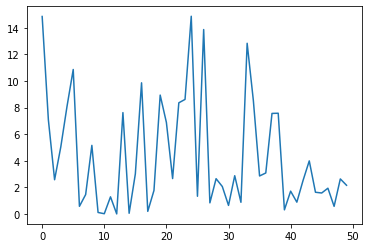

In [66]:
plt.plot(history)